### Imports

In [1]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [2]:
!pwd

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text import *

In [5]:
from ulmfit.pretrain_lm import *

In [6]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

### Preparing data

In [7]:
# batch size
bs = 30

In [8]:
# use data from smaller sample of wiki
# data is recieved through prepare_wiki.sh script
wiki_data_path = Path('data/wiki/ru-100/')

In [9]:
wiki_data_path.ls()

[PosixPath('data/wiki/ru-100/ru.wiki.test.tokens'),
 PosixPath('data/wiki/ru-100/ru.wiki.valid.tokens'),
 PosixPath('data/wiki/ru-100/ru.wiki.train.tokens'),
 PosixPath('data/wiki/ru-100/models')]

In [10]:
# provide train and valid path
trn_path = wiki_data_path/'ru.wiki.train.tokens'
val_path = wiki_data_path/'ru.wiki.valid.tokens'

In [11]:
# create a databunch object from data_frames
# data_frames are provided through `read_wiki_articles` function
# from `ulmfit.pretrain_lm`
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [12]:
itos = data_lm.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'в', 'и', '\n\n', 'на', ')', '(', '\n', '—', '«', '»']


In [13]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(189786, 447)

In [14]:
data_lm.train_ds[0][0]

Text xxbos = xxmaj розовая чайка = 
 xxmaj розовая чайка 

 xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 

 xxmaj описание . 
 xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 

 xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 

 xxmaj xxunk . 
 xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнообразием . xxmaj чаще всего xxunk крик вроде « э - у , э - у » ; xxunk , они издают короткий крик « xxunk , xxunk , xxunk » , если очень xxunk — « xxunk - xxunk » , а при нападении другой чайки того же вида или xxunk

In [15]:
data_lm.show_batch()

idx,text
0,"xxbos \n = xxmaj xxunk xxmaj xxunk = \n xxmaj xxunk xxmaj xxunk \n\n — японская манга , автором которой является xxmaj xxunk xxmaj кавасаки . xxmaj публиковалась издательством xxmaj xxunk в журнале xxmaj xxunk no xxmaj xxunk xxmaj xxunk . xxmaj манга выиграла 14 премию xxmaj xxunk . xxmaj по мотивам манги студией xxmaj xxunk xxmaj production был выпущен аниме - сериал . xxmaj всего выпущены 104 серии аниме"
1,". \n\n xxmaj xxunk . \n xxmaj xxunk ́ тка ( ) — часть xxunk трубки и дыхательных путей , которая является xxunk звеном между xxunk носа и рта , с одной стороны , и xxunk и xxunk — с другой . xxmaj представляет собой xxunk канал длиной 11 — 12 см , обращённый кверху широким концом и xxunk в xxunk направлении . xxmaj верхняя стенка xxunk с основанием черепа"
2,"трамвая 12 xxunk xxmaj xxunk ( нынешний мясокомбинат на аллее xxmaj xxunk ) — xxmaj xxunk xxunk ( & ' , & ' ул . xxmaj xxunk ) . 4 мая того же года открылся маршрут e xxmaj xxunk ворота — пригород xxmaj xxunk ( & ' , & ' пос . xxmaj октябрьское ) . в 1940 или 1941 году для перевозки рабочих к xxunk xxmaj xxunk начал действовать"
3,"расположен в 42 км от столицы республики — города xxmaj нальчик . \n\n xxmaj все населённые пункты района имеют xxunk xxunk сообщение с районным центром , а также городами xxmaj нальчик и xxmaj xxunk . \n\n\n xxbos \n = xxmaj кларк , xxmaj билли = \n xxmaj кларк , xxmaj билли \n\n xxmaj уильям ( xxmaj билл ) xxmaj чарльз xxmaj кларк ( ; родился 27 декабря 1987 , xxmaj"
4,"м. xxmaj соболев ( xxmaj израиль ) , ( xxmaj великобритания ) , xxup к. xxmaj эмерсон ( xxup сша ) . \n\n\n xxbos \n = xxmaj карл xxup xiv xxmaj юхан = \n xxmaj карл xxup xiv xxmaj юхан \n\n xxmaj жан - xxmaj xxunk ́ ст xxmaj жюль xxmaj xxunk ́ т ( , впоследствии xxmaj карл xxup xiv ю ́ хан , ; 26 января 1763 ,"


In [16]:
# save databunch
data_lm.save('tmp_lm')

In [10]:
# load databunch
data_lm = TextLMDataBunch.load(wiki_data_path, 'tmp_lm', bs=bs)

#### Create Learner and train Language Model

In [17]:
# create learner for training on wiki from scratch
learner = language_model_learner(data=data_lm, drop_mult=1.0)

In [18]:
# change Adam default params
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [19]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [20]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f2935961d08>>]

In [21]:
# add save callback
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm'),
                         partial(CSVLogger, filename=f"{learner.model_dir}/lm-history")]

In [22]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm'),
 functools.partial(<class 'fastai.callbacks.csv_logger.CSVLogger'>, filename='models/lm-history')]

In [23]:
# unfreeze all layers
learner.unfreeze()

In [24]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


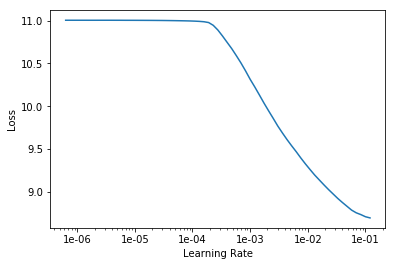

In [25]:
learner.recorder.plot(skip_end=15)

In [26]:
# define non-default momentums
moms=(0.8,0.7)

In [27]:
learner.fit_one_cycle(15, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.415810,4.170653,0.370578
2,4.064283,3.720713,0.404269
3,3.860178,3.546426,0.419223
4,3.726555,3.504621,0.420514
5,3.746197,3.460210,0.423597
6,3.770828,3.435968,0.424416
7,3.705463,3.425619,0.428478
8,3.736794,3.403164,0.430741
9,3.607583,3.372716,0.434384
10,3.662338,3.363870,0.435925


In [ ]:
# save model
learner.save('ru-100-best')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### Fine tune on ruSentEval Unsupervised data

http://study.mokoron.com/ - I get sample data from ~17M tweets database

In [7]:
# path for ruSentiment data
rusent_data_path = Path('data/ruSentiment/')

In [8]:
bs = 48

In [9]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [10]:
# create LM DataBunch from ruSentEval unsupervised corpus of tweets sample (http://study.mokoron.com/)
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'unsup_sample.csv', text_cols=0,
                                    valid_pct=0.1, bs=bs)

In [11]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '/', ':', ',', 'http', 't.co', '.', 'в', '#', 'rt', 'и', 'не', '-']
data/ruSentiment


In [12]:
(data1_lm.path).ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [13]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(1799487, 199944)

In [14]:
data1_lm.show_batch()

idx,text
0,"xxbos я очень надеюсь что этой осенью , у каждого из нас будет тот , кто будет греть нам руки . xxbos @thedaemondevil ты играл в снежки ? xxbos http : / / t.co / xxunk нтв похудение xxbos xxmaj нас затащили в мужскую раздевалку , мы xxunk , как могли xxbos я так люблю xxunk ручкой и бесить всех этим xxbos http : / / t.co / xxunk биология"
1,"тот , кого любишь ты , полюби того , кто тебя любит , он будет с тобой всегда и не предаст . xxbos а xxup нет xxup милашка xxup ты xxup мой xxup любимый xxup начал xxup грузить xxbos xxup rt xxunk : xxmaj когда xxmaj чак xxmaj норрис xxunk xxunk барьер , у xxmaj россии не останется выбора xxbos xxmaj курс — за безопасность ! xxbos xxmaj билл"
2,"xxbos xxunk xxunk xxunk ккк . харин тийм юм байна xxbos xxunk поле большое , и слабый состав , время катать рукава xxunk , \n но не xxunk домашний устав , время подумать камни xxunk xxbos xxup rt xxunk : xxmaj раньше я считал , что люди , xxunk в семь утра на работу - несчастные ебанутые xxunk . \n xxmaj теперь я встаю в xxunk и знаю … xxbos"
3,"в полосу черного отчаяния . # autofollowback xxbos xxup rt @th_no : xxmaj каждый день мечтаю уехать далеко - далеко от всего . xxbos xxup опг в штабе xxbos « легенды xxunk » с xxunk xxunk ( 2009 ) xxunk xxunk http : / / t.co / xxunk xxbos xxunk подача от xxmaj xxunk xxbos xxup rt @koffboy : xxmaj первый канал : "" в xxmaj киеве на"
4,": xxmaj хочу горячий шоколад . xxbos xxmaj блюз в голове =) xxbos 8 декабря – xxmaj день образования российского казначейства http : / / t.co / xxunk xxbos # хочупровестиновогоднююночьвместес xxunk @after_red_lotus xxunk @zellibaba @diana_yankumi xxunk xxbos ахахах , сидела рассказывала любовный стих смотрю на xxmaj криса на экране : xxup ddd xxbos xxup rt @topcitata : я xxup так xxup хочу xxup спать , что приду и сразу"


In [15]:
data1_lm.train_ds[0]

(Text xxbos http : / / t.co / xxunk сколько калорий нужно в день чтобы похудеть,
 Category 0)

In [16]:
# save data bunch 
data1_lm.save('tmp_lm')

In [9]:
data1_lm = TextLMDataBunch.load(rusent_data_path, 'tmp_lm', bs=bs)

#### Create Learner and Finetune model from pretrained fnames

In [17]:
# pretrained model and vocab from first step of training LM
pretrained_fnames = ['ru-100-best', 'itos']

In [18]:
# create learner and provide pretrained files to finetune wiki-LM with ruSentiment data
learner = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=1.0)

Unknown tokens 32951, first 100: ['t.co', 'rt', '"', 'mtvstars', 'seconds', 'direction', 'гдз', ':)', '\xa0', ':d', 'gameinsight', ':3', 'решебник', 'androidgames', 'шлюхи', 'имбирем', 'блять', 'блин', 'justin', 'bieber', 'бля', 'ненавижу', 'ахах', 'пойду', '©', 'ахаха', '@youtube', 'євромайдан', 'массаж', 'пиздец', 'твит', '️', 'хд', 'ipadgames', 'сижу', 'похудения', 'твиттер', 'сука', ':(', 'ладно', 'смотрю', 'евромайдан', 'ахахах', 'андроид', 'жду', ';)', 'лол', 'нахуй', 'урока', 'торрент', '❤', '\xa0 ', 'конспект', 'обожаю', 'хочупровестиновогоднююночьвместес', 'прям', ':-)', 'бесит', 'болит', 'дp', 'щас', '4о', 'майдан', 'о5', 'o5', '4o', '^^', 'бл', 'ищу', '♥', 'проверь', 'ретвит', 'фгос', '11.12.13', '@koffboy', 'боюсь', 'жуйк', 'грядки', 'майдане', 'ох', 'скучаю', '@5umm', ':*', 'ответами', 'чувак', 'любишь', 'тви', 'делаю', 'интим', 'радует', 'янукович', 'ахахаха', 'реферат', '<3', 'лень', 'говно', 'iphonegames', 'хуй', 'follow', '14:15']


In [19]:
learner.callback_fns += [partial(CSVLogger, filename=f"{learner.model_dir}/lm-history"),
                         partial(SaveModelCallback, every='epoch', name='lm')]

In [20]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.csv_logger.CSVLogger'>, filename='models/lm-history'),
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [21]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [22]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [23]:
learner.true_wd

True

In [24]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f2974d3ad08>>]

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


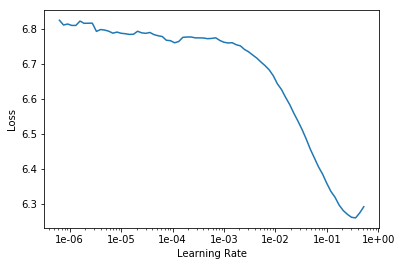

In [26]:
learner.recorder.plot(skip_end=15)

In [27]:
moms = (0.8, 0.7)

In [28]:
# learning the same way as in fastai v1 examples
learner.fit_one_cycle(1, 2e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.130555,3.831492,0.400419


In [29]:
learner.save('fit_head')

In [23]:
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (1799487 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (1799487 items)
[Text xxbos xxup rt xxunk : в xxunk дверь , xxunk на пороге , xxunk xxunk походкой xxunk и xxunk ., Text xxbos xxmaj смерть стучится ко всем одинаково ., Text xxbos xxunk похоже ты xxunk :), Text xxbos xxmaj мужчина должен найти правильную цель в жизни , а женщина — мужчину с правильной целью . xxunk xxmaj шоу, Text xxbos xxup rt @dany_belik : xxmaj шизофрения - это удобно . xxmaj всегда есть с кем xxunk]...
Path: data/ruSentiment;

Valid: LabelList
y: LMLabel (199944 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (199944 items)
[Text xxbos xxunk да, Text xxbos @nashka_ya ну ок , я ща выхожу ток, Text xxbos xxup rt xxunk : xxmaj хера я такой ленивый ☺ ️, Text xxbos xxunk не гордиться невозможно ) и все же у меня есть надежда , чт

In [30]:
learner.unfreeze()

In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


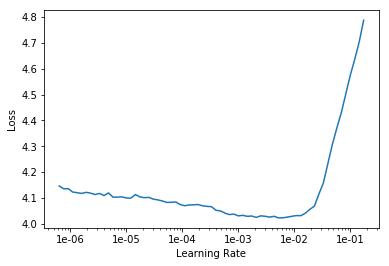

In [32]:
learner.recorder.plot(skip_end=15)

In [33]:
learner.fit_one_cycle(20, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,3.731477,3.577709,0.425491
2,3.602426,3.457837,0.440030
3,3.510994,3.365776,0.452591
4,3.449723,3.304654,0.460721
5,3.415729,3.259692,0.466675
6,3.371386,3.220406,0.471379
7,3.314525,3.188998,0.475213
8,3.294283,3.159852,0.478213
9,3.270088,3.140334,0.480448
10,3.244588,3.123124,0.482408


In [34]:
# save fine_tuned model
learner.save('fine_tuned')

In [35]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned_enc')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [27]:
# check text generation with LM
TEXT = "сегодня утром я"
N_WORDS = 10
N_SENTENCES = 2

In [28]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

сегодня утром я пороки росомаха снимаю зафиксировали финляндию истинного посадит @homutoov вредно открываются
сегодня утром я декабр финансовых кеша фрагмент интимдосуг славе паразит растущие рода @sweetmolko


### Classifier

Here we are working on ruSentiment classification task from http://text-machine.cs.uml.edu/projects/rusentiment/

In [10]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/merg_rusenteval_rusent.csv'),
 PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/unsup_sample.csv'),
 PosixPath('data/ruSentiment/tmp_clas'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/unsup-no-null.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [11]:
rand = pd.read_csv(rusent_data_path/'rusentiment_random_posts.csv')
presel = pd.read_csv(rusent_data_path/'rusentiment_preselected_posts.csv')

In [12]:
# create classification databunch, please note usage of LM vocab
# as a train data we use both random posts and preselected posts
# and testset to mesure quality of classifier
data_clas = TextClasDataBunch.from_df(path=rusent_data_path,
                                      train_df=pd.concat([rand, presel], ignore_index=True),
                                      valid_df=pd.read_csv(rusent_data_path/'rusentiment_test.csv'),
                                      vocab=data1_lm.vocab, text_cols='text', label_cols='label', bs=bs)

In [13]:
data_clas.show_batch()

text,target
xxbos xxmaj xxunk прошлое в огне … xxmaj гори все \n xxunk … \n xxmaj не xxunk ни о чем … xxmaj забудьте \n xxunk ! \n xxmaj не вспоминайте о плохом … и о \n хорошем … \n xxmaj не собирайте под столом … от \n счастья xxunk … \n xxmaj ведь вы достойны не кусков … и не \n xxunk … \n xxmaj лишь стоит руку xxunk …,neutral
"xxbos [ xxunk ] xxup xxunk ! ! ! \n\n [ xxunk ] с xxup пеной у xxup рта xxup написал xxup пост xxup про xxup xxunk xxup движения xxmaj xxunk xxup команды xxup во xxup главе с [ xxunk xxmaj xxunk xxmaj xxunk ] , xxup xxunk xxup против xxup xxunk , в xxup том xxup числе и xxup против xxup самого [ xxunk № 2 xxmaj россии ]",negative
"xxbos , , xxunk сказано ахаха , , \n\n xxup вк - не жизнь . \n xxup сп - не чувства . \n xxup вк - xxup не xxup жизнь ? xxup нуну xxup блять . xxup тут xxup ты xxup находишь xxup xxunk xxup друзей , xxup подруг . xxup которым xxup можешь xxup xxunk xxup абсолютно xxup всё xxup рассказать и xxup уверена xxup что xxup они xxup",skip
"xxbos xxmaj завтра вечером улетаю в xxmaj израиль . \n xxmaj на 3 недели * в этом месте исполняется радостный xxunk \n xxmaj буду отдыхать и смотреть красоты . \n xxmaj для связи со мной лучше всего использовать ( в порядке уменьшения xxunk ) : \n 1 . xxmaj почту xxunk . xxmaj буду проверять как можно чаще , по мере доступа . \n 2 . xxmaj",neutral
"xxbos xxmaj xxunk взгляды . xxmaj всё чаще пофиг . \n xxmaj уснуть , забыться … xxmaj на утро кофе . \n xxmaj усталость . xxmaj тошно . xxmaj но кто - то рядом . \n в подушку xxunk : « xxmaj прошу , не надо ! » \n\n xxmaj работа . xxmaj кофе . и дым с xxunk . \n xxmaj ты стала стервой ? xxmaj да нет …",negative


In [14]:
# number of classes
data_clas.train_ds.c

5

In [15]:
# classes labels
data_clas.train_ds.classes

['negative', 'neutral', 'positive', 'skip', 'speech']

In [16]:
data_clas

TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: data/ruSentiment
x: TextList (28218 items)
[Text xxbos а попа xxunk давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: data/ruSentiment
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos xxunk ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году

In [17]:
len(data_clas.vocab.itos)

60003

In [18]:
data_clas.batch_size

24

In [19]:
# save for future use
data_clas.save('tmp_clas')

In [12]:
data_clas = TextClasDataBunch.load(rusent_data_path, 'tmp_clas', bs=bs)

#### Training

In [41]:
# create learner and train
# train classifier as in fastai imdb example
learner = text_classifier_learner(data=data_clas, drop_mult=0.5)

In [42]:
# load fine tuned encoder
learner.load_encoder('fine_tuned_enc')

In [43]:
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='cls')]

In [44]:
learner.freeze()

In [45]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


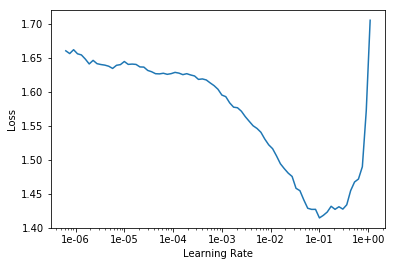

In [46]:
learner.recorder.plot()

In [47]:
moms=(0.8,0.7)

In [48]:
learner.fit_one_cycle(1, 2e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,1.008391,0.814530,0.683856


In [49]:
learner.save('first')

In [14]:
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (21268 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (21268 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxun

In [50]:
learner.freeze_to(-2)

In [51]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


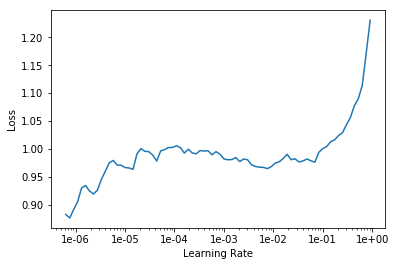

In [52]:
learner.recorder.plot()

In [53]:
learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.900239,0.726347,0.716549


In [54]:
learner.save('second')

In [36]:
learner.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (21268 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (21268 items)
[Text xxbos а попа подозревала давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos помниш ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxun

In [55]:
learner.freeze_to(-3)

In [56]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


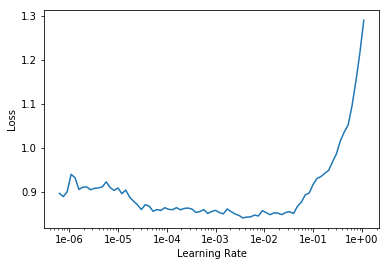

In [57]:
learner.recorder.plot()

In [58]:
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.822611,0.694943,0.733064


In [59]:
learner.save('third')

In [36]:
learner.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (28218 items)
[Text xxbos а попа xxunk давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos xxunk ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxunk готов

In [60]:
learner.unfreeze()

In [61]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


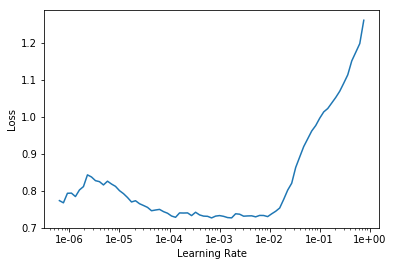

In [62]:
learner.recorder.plot()

In [63]:
learner.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.718630,0.694408,0.729356
2,0.737847,0.686142,0.732053
3,0.626939,0.702200,0.726997
4,0.581366,0.728239,0.720593


In [64]:
learner.load('cls_2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: .
x: TextList (28218 items)
[Text xxbos а попа xxunk давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: .
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos xxunk ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 ) 
 к новому году в xxunk готов

In [65]:
learner.save('best-classifier')

In [114]:
learner.load('best-classifier')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (28218 items)
[Category negative, Category speech, Category skip, Category negative, Category skip]...
Path: data/ruSentiment
x: TextList (28218 items)
[Text xxbos а попа xxunk давно , что ты с кавказа .. перестану общаться с тобой, Text xxbos з прошедшим xxmaj днем xxmaj ангела xxrep 8 ), Text xxbos xxmaj два дня до xxunk с острова xxrep 7 !, Text xxbos xxmaj блин , почему эта жизнь столь не справедлива xxrep 4 (, Text xxbos где еще встречать свой день рождения как не на кладбище xxrep 4 )]...
Path: data/ruSentiment;

Valid: LabelList
y: CategoryList (2967 items)
[Category neutral, Category positive, Category neutral, Category skip, Category speech]...
Path: data/ruSentiment
x: TextList (2967 items)
[Text xxbos xxmaj александр , тебе к лицу эта пушка :) 
, Text xxbos xxmaj скоро ты вернешься домой , грязный , не xxunk но такой любимый ❤, Text xxbos xxunk ... ) ), Text xxbos xxmaj мы просто с [ xxunk ] xxunk xxrep 5 )

In [66]:
# sanity check for accuracy, precision, recall and f1-score
preds, targets = learner.get_preds()

In [67]:
targets.unique()

tensor([4, 0, 2, 3, 1])

In [68]:
pred_classes = torch.argmax(preds, dim=1)

In [69]:
np.set_printoptions(precision=3)

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

In [71]:
print(classification_report(targets, pred_classes, 
                            target_names=data_clas.train_ds.classes, digits=4))

              precision    recall  f1-score   support

    negative     0.6034    0.5426    0.5714       258
     neutral     0.7973    0.7838    0.7905      1420
    positive     0.6558    0.6362    0.6458       536
        skip     0.4881    0.5347    0.5103       346
      speech     0.8932    0.9656    0.9280       407

   micro avg     0.7321    0.7321    0.7321      2967
   macro avg     0.6876    0.6926    0.6892      2967
weighted avg     0.7320    0.7321    0.7315      2967



In [72]:
# check prediction for one example
learner.predict('сомнительная перспектива')

(Category neutral, tensor(1), tensor([0.0297, 0.4309, 0.2130, 0.3250, 0.0014]))

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 140   82   15   21    0]
 [  56 1113  119  116   16]
 [   9  114  341   53   19]
 [  27   83   39  185   12]
 [   0    4    6    4  393]]
Normalized confusion matrix
[[0.543 0.318 0.058 0.081 0.   ]
 [0.039 0.784 0.084 0.082 0.011]
 [0.017 0.213 0.636 0.099 0.035]
 [0.078 0.24  0.113 0.535 0.035]
 [0.    0.01  0.015 0.01  0.966]]


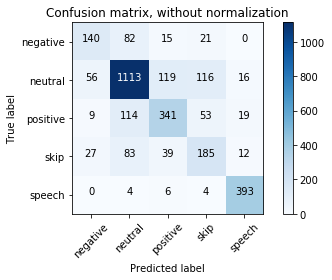

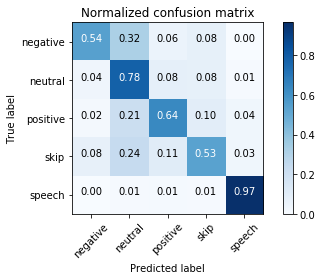

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(targets, pred_classes)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=data_clas.train_ds.classes,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=data_clas.train_ds.classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()